In [1]:
import pandas as pd

# Data Cleaning

In [2]:
# load the csv file
df = pd.read_csv("nord_columbia_dress.csv") 
#df

## add column names

In [3]:
# sample file 
sample_df = pd.read_csv("Columbia_Data_Sample.csv")
sample_df

# delete 4 columns to match with dataset

sample_df1=sample_df
del sample_df1['RCD_LOAD_TSTAMP']
del sample_df1['TYPE_LEVEL_2_NUM']
del sample_df1['COLOR_NUM']
del sample_df1['TYPE_LEVEL_1_NUM']
# sample_df1

In [4]:
# add column name to original data
df.columns = sample_df1.columns
df.columns
len(df)

6418709

## filter dropship that is 1

In [5]:
# DROPSHIP_IND: indicator if CC is dropship, meaning we don't own the inventory and once purchased by a customer, its shipped directly from the vendor

condition = df['DROPSHIP_IND'] == 0

df = df[condition]
len(df)

5010325

## Dealing with NAN

In [6]:

# Inputting missing values for categorical attribute. 

df.loc[df['SELLING_STATUS_CODE'].isna(), 'SELLING_STATUS_CODE'] = "None"
df.loc[df['GENDERS_DESC'].isna(), 'GENDERS_DESC'] = "Not Specified"
df.loc[df['CURRENT_DISCOUNT'].isna(), 'CURRENT_DISCOUNT'] = 0
df.loc[df['EVENT_TAGS'].isna(), 'EVENT_TAGS'] = "None"
df.loc[df['AGE_GROUPS_DESC'].isna(), 'AGE_GROUPS_DESC'] = "None"


# drop the na data (dropped only one row)
df=df.dropna(subset=['REGULAR_PRICE_AMT','CURRENT_PRICE_AMT'], how='any')

In [7]:
# replace all the na 

mean_values = df.groupby('CC')['cost_per_unit'].transform('mean')
df['cost_per_unit'] = df['cost_per_unit'].fillna(mean_values)
mean_values1=df.groupby('RMS_STYLE_NUM')['cost_per_unit'].transform('mean')
df['cost_per_unit'] = df['cost_per_unit'].fillna(mean_values1)
mean_values2=df.groupby('MODEL_CATEGORY')['cost_per_unit'].transform('mean')
df['cost_per_unit'] = df['cost_per_unit'].fillna(mean_values2)

## keep all data from ones that has been marked as RP==1

In [8]:
# check (only date columns should contain na)
columns_with_nan = df.columns[df.isna().any()].tolist()

df_RP1 = df[df['RP_IND'] == 1]
df_RP0 = df[df['RP_IND'] != 1]



unique_CC_in_rp_1 = df_RP1['CC'].unique()
df_RP_CC = df[df['CC'].isin(unique_CC_in_rp_1)]



df_RP_CC['WK_START_DT'] = pd.to_datetime(df_RP_CC['WK_START_DT'])
len(df_RP_CC)

/var/folders/ty/f2jjynbj7rn6t30v8cf0215h0000gn/T/ipykernel_50955/4037871403.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RP_CC['WK_START_DT'] = pd.to_datetime(df_RP_CC['WK_START_DT'])


33979

# prophet model

In [9]:
data = df_RP_CC.copy()

In [10]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from math import sqrt

/Users/shenyuxin/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Prepare the holiday dataframe for the Prophet model
holidays_df = data[data['PROMO_DAYS'] > 0][['WK_START_DT']].drop_duplicates()
holidays_df.rename(columns={'WK_START_DT': 'ds'}, inplace=True)
holidays_df['holiday'] = 'Promotion'

# Aggregate the data by 'CC' and 'WK_START_DT' with sum values of the metrics
clustered_data = data.groupby(['CC', 'WK_START_DT']).agg({
    'SALES_QTY': 'sum',
    'PROMO_DAYS': 'sum',
    'ATB': 'sum',
    'SOH': 'sum',
    'SALES_AMT': 'sum',
    'PVS':'sum',
    'cost_per_unit':'mean'
}).reset_index()

# Calculating the count of records for each CC
cc_counts = clustered_data['CC'].value_counts()

#Filter data >= median_records (145 weeks)
sufficient_data_ccs = cc_counts[cc_counts >= 52].index
clustered_data = clustered_data[clustered_data['CC'].isin(sufficient_data_ccs)]

# Calculate the proportion of 'RP_IND' being 1
clustered_data['RP_IND_prop'] = data.groupby(['CC', 'WK_START_DT'])['RP_IND'].mean().reset_index(drop=True)

# Define a holiday column based on whether PROMO_DAYS > 0
clustered_data['HOLIDAY'] = clustered_data['PROMO_DAYS'] > 0

# Rename 'CC' to 'Cluster' for clarity
clustered_data.rename(columns={'CC': 'Cluster'}, inplace=True)

# Display the first few rows of the preprocessed data
clustered_data.head()

Cluster WK_START_DT  SALES_QTY  PROMO_DAYS  ATB  SOH  SALES_AMT  PVS  \
0  10160694-114  2021-01-31         42           0   88  914    5668.90  0.0   
1  10160694-114  2021-02-07          2           0    7    6      73.94  0.0   
2  10160694-114  2021-02-14          1           0    4    4      36.97  0.0   
3  10160694-114  2021-02-21          0           0    1    3       0.00  0.0   
4  10160694-114  2021-02-28          0           0    6    3       0.00  0.0   

   cost_per_unit  RP_IND_prop  HOLIDAY  
0      42.472919          0.5    False  
1      42.103448          0.0    False  
2      42.103448          0.0    False  
3      42.103448          0.0    False  
4      42.103448          0.0    False

In [12]:
# Initialize a dictionary to hold forecasts and RMSE for each cluster
cluster_forecasts = {}
cluster_rmse = {}
standardized_rmse = {}

# Define the number of periods to hold out for the test set
n_test_periods = 12  # For example, if your data is weekly, this would hold out the last 12 weeks for testing

# Loop over each unique cluster
for cluster in clustered_data['Cluster'].unique():
    # Filter the DataFrame for the current cluster
    cluster_data = clustered_data[clustered_data['Cluster'] == cluster]
    
    if len(cluster_data) <= (n_test_periods + 1):
        print(f"Cluster {cluster} has insufficient data. Skipping.")
        continue

    # Split the data into training and testing sets
    train_df = cluster_data.iloc[:-n_test_periods]
    test_df = cluster_data.iloc[-n_test_periods:]

    # Prepare the DataFrame for Prophet (without log transformation)
    prophet_df = train_df.rename(columns={'WK_START_DT': 'ds', 'SALES_QTY': 'y'}).copy()

    # Initialize the Prophet model with specified parameters and holidays
    m = Prophet(
#         growth='linear',
        seasonality_mode='multiplicative',
        interval_width=0.95,
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=True,
        holidays=holidays_df  # Assuming holidays_df is defined
    )

    # Add other regressors to the Prophet model
    m.add_regressor('SOH')
    m.add_regressor('SALES_AMT')
    m.add_regressor('ATB')
    m.add_regressor('RP_IND_prop')
    m.add_regressor('PVS')
    
    m.fit(prophet_df)

    # Now that the model is fitted, create a future DataFrame for forecasting
    future = m.make_future_dataframe(periods=n_test_periods, freq='W')
    
    def predict_regressor(regressor_series, periods, future_df_length):
        # Fit a model to the historical data
        X = np.arange(len(regressor_series)).reshape(-1, 1)
        y = regressor_series.values
        model = LinearRegression().fit(X, y)

        # Predict future values
        X_future = np.arange(len(regressor_series), future_df_length).reshape(-1, 1)
        predictions_future = model.predict(X_future)

        # Concatenate historical and future values
        return np.concatenate((regressor_series.values, predictions_future))

    future_df_length = len(future)

    # Predict future values for regressors and add to the future DataFrame
    future['ATB'] = predict_regressor(train_df['ATB'], n_test_periods, future_df_length)
    future['SALES_AMT'] = predict_regressor(train_df['SALES_AMT'], n_test_periods, future_df_length)
    future['RP_IND_prop'] = predict_regressor(train_df['RP_IND_prop'], n_test_periods, future_df_length)
    future['SOH'] = predict_regressor(train_df['SOH'], n_test_periods, future_df_length)
    future['PVS'] = predict_regressor(train_df['PVS'], n_test_periods, future_df_length)

    # Make predictions for the test set
    forecast = m.predict(future)
    
    # Store the forecast in the dictionary with the cluster as the key
    cluster_forecasts[cluster] = forecast

    # Directly use the forecasted 'yhat' values without exponential transformation
    forecasted_values = forecast['yhat'][-n_test_periods:]
    actual_values = test_df['SALES_QTY']
    rmse = sqrt(mean_squared_error(actual_values, forecasted_values))
    cluster_rmse[cluster] = rmse

    # Calculate the mean for the sales quantity in the current cluster
    sales_mean = test_df['SALES_QTY'].mean()

    # Calculate and store standardized RMSE
    if sales_mean != 0:
        standardized_rmse_value = rmse / sales_mean
    else:
        standardized_rmse_value = rmse  # Avoid division by zero
    standardized_rmse[cluster] = standardized_rmse_value




23:17:18 - cmdstanpy - INFO - Chain [1] start processing
23:17:18 - cmdstanpy - INFO - Chain [1] done processing
23:17:19 - cmdstanpy - INFO - Chain [1] start processing
23:17:19 - cmdstanpy - INFO - Chain [1] done processing
23:17:19 - cmdstanpy - INFO - Chain [1] start processing
23:17:19 - cmdstanpy - INFO - Chain [1] done processing
23:17:19 - cmdstanpy - INFO - Chain [1] start processing
23:17:19 - cmdstanpy - INFO - Chain [1] done processing
23:17:19 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:39 - cmdstanpy - INFO - Chain [1] start processing
23:17:39 - cmdstanpy - INFO - Chain [1] done processing
23:17:39 - cmdstanpy - INFO - Chain [1] start processing
23:17:39 - cmdstanpy - INFO - Chain [1] done processing
23:17:39 - cmdstanpy - INFO - Chain [1] start processing
23:17:39 - cmdstanpy - INFO - Chain [1]

## CC rmse

In [13]:
standardized_rmse=pd.DataFrame(list(standardized_rmse.items()),columns=['Cluster','Standardize_RMSE'])

Cluster_CC_list=standardized_rmse[standardized_rmse['Standardize_RMSE']<10]['Cluster']

In [14]:
Cluster_catg_list=standardized_rmse[standardized_rmse['Standardize_RMSE']>=10]['Cluster']
clustered_data_by_CC=clustered_data[clustered_data['Cluster'].isin(Cluster_CC_list)]


In [15]:
cluster_forecasts = {}

# Define the number of periods to hold out for the test set and future prediction
n_test_periods = 12  # This is for the test set
n_future_periods = 12  # Additional periods for future prediction

# Loop over each unique cluster
for cluster in clustered_data_by_CC['Cluster'].unique():
    # Filter the DataFrame for the current cluster
    cluster_data = clustered_data_by_CC[clustered_data_by_CC['Cluster'] == cluster]
    
    if len(cluster_data) <= (n_test_periods + 1):
        print(f"Cluster {cluster} has insufficient data. Skipping.")
        continue

    # Split the data into training and testing sets
    train_df = cluster_data.iloc[:-n_test_periods]

    # Prepare the DataFrame for Prophet (without log transformation)
    prophet_df = train_df.rename(columns={'WK_START_DT': 'ds', 'SALES_QTY': 'y'}).copy()

    # Initialize the Prophet model with specified parameters and holidays
    m = Prophet(
        growth='linear',
        seasonality_mode='multiplicative',
        interval_width=0.95,
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        holidays=holidays_df  # Assuming holidays_df is defined
    )

    # Add other regressors to the Prophet model
    m.add_regressor('SOH')
    m.add_regressor('SALES_AMT')
    m.add_regressor('ATB')
    m.add_regressor('RP_IND_prop')
    m.add_regressor('PVS')

    # Fit the model to the training data
    m.fit(prophet_df)

    # Create a future DataFrame for forecasting beyond the available data
    future_periods = n_test_periods + n_future_periods
    future = m.make_future_dataframe(periods=future_periods, freq='W')

    future_df_length = len(future)

    # Function to predict regressor values into the future
    def predict_regressor(regressor_series, future_df_length):
        # Fit a model to the historical data
        X = np.arange(len(regressor_series)).reshape(-1, 1)
        y = regressor_series.values
        model = LinearRegression().fit(X, y)

        # Predict future values
        X_future = np.arange(len(regressor_series), future_df_length).reshape(-1, 1)
        predictions_future = model.predict(X_future)

        # Concatenate historical and future values
        return np.concatenate((regressor_series.values, predictions_future))

    # Predict future values for regressors and add to the future DataFrame
    future['ATB'] = predict_regressor(train_df['ATB'], future_df_length)
    future['SALES_AMT'] = predict_regressor(train_df['SALES_AMT'], future_df_length)
    future['RP_IND_prop'] = predict_regressor(train_df['RP_IND_prop'], future_df_length)
    future['SOH'] = predict_regressor(train_df['SOH'], future_df_length)
    future['PVS'] = predict_regressor(train_df['PVS'], future_df_length)

    # Make predictions for the extended future period
    forecast = m.predict(future)

    # Store the forecast in the dictionary with the cluster as the key
    cluster_forecasts[cluster] = forecast

    all_cluster_forecasts_df = pd.DataFrame()

    # Extract and consolidate forecast results for each cluster into a DataFrame
    for cluster, forecast in cluster_forecasts.items():
        future_forecast = forecast.tail(n_future_periods)  # Extract the last 12 weeks of predictions
        future_forecast['Cluster'] = cluster  # Add a column for the cluster
        all_cluster_forecasts_df = pd.concat([all_cluster_forecasts_df, future_forecast], ignore_index=True)

    # Select relevant columns
    all_cluster_forecasts_df = all_cluster_forecasts_df[['Cluster', 'ds', 'yhat', 'yhat_lower', 'yhat_upper']]

23:20:51 - cmdstanpy - INFO - Chain [1] start processing
23:20:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/ty/f2jjynbj7rn6t30v8cf0215h0000gn/T/ipykernel_50955/3928422641.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['Cluster'] = cluster  # Add a column for the cluster
23:20:51 - cmdstanpy - INFO - Chain [1] start processing
23:20:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/ty/f2jjynbj7rn6t30v8cf0215h0000gn/T/ipykernel_50955/3928422641.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [16]:
all_cluster_forecasts_df['yhat'] =all_cluster_forecasts_df['yhat'].apply(lambda x: np.ceil(x) if x > 0 else 0)
pred_sales_qty_CC_level=all_cluster_forecasts_df[['Cluster','ds', 'yhat']]

In [17]:
large_rmse_data=data[data['CC'].isin(Cluster_catg_list)]
# large_rmse_data

In [18]:
# Prepare the holiday dataframe for the Prophet model
holidays_df = large_rmse_data[large_rmse_data['PROMO_DAYS'] > 0][['WK_START_DT']].drop_duplicates()
holidays_df.rename(columns={'WK_START_DT': 'ds'}, inplace=True)
holidays_df['holiday'] = 'Promotion'

# Sum values for same CC with same WK_START_DT (combining Northstrom and Northstrom_Rack)
clustered_data_ctg = large_rmse_data.groupby(['CATEGORY','CC', 'WK_START_DT']).agg({
    'SALES_QTY': 'sum',
    'PROMO_DAYS': 'sum',
    'ATB': 'sum',
    'SOH': 'sum',
    'SALES_AMT': 'sum',
    'PVS':'sum'
}).reset_index()

clustered_data_ctg = clustered_data_ctg.groupby(['CATEGORY','WK_START_DT']).agg({
    'SALES_QTY': 'mean',
    'PROMO_DAYS': 'mean',
    'ATB': 'mean',
    'SOH': 'mean',
    'SALES_AMT': 'mean',
    'PVS':'mean'
}).reset_index()

# Calculating the count of records for each CC
cc_counts = clustered_data_ctg['CATEGORY'].value_counts()

#Filter data >= median_records (145 weeks)
sufficient_data_ccs = cc_counts[cc_counts >= 52].index
clustered_data_ctg = clustered_data_ctg[clustered_data_ctg['CATEGORY'].isin(sufficient_data_ccs)]

# Calculate the proportion of 'RP_IND' being 1
clustered_data_ctg['RP_IND_prop'] = data.groupby(['CATEGORY','WK_START_DT'])['RP_IND'].mean().reset_index(drop=True)

# Define a holiday column based on whether PROMO_DAYS > 0
clustered_data_ctg['HOLIDAY'] = clustered_data_ctg['PROMO_DAYS'] > 0

# Rename 'CC' to 'Cluster' for clarity
clustered_data_ctg.rename(columns={'CATEGORY': 'Cluster'}, inplace=True)

# Display the first few rows of the preprocessed data
# clustered_data_ctg.head()

## Train & Test graph output

23:22:58 - cmdstanpy - INFO - Chain [1] start processing
23:22:58 - cmdstanpy - INFO - Chain [1] done processing


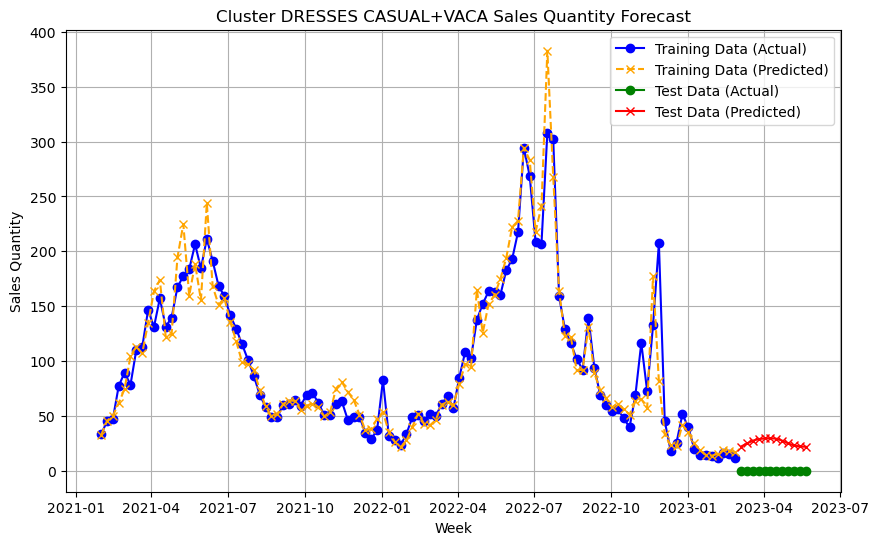

23:22:58 - cmdstanpy - INFO - Chain [1] start processing
23:22:58 - cmdstanpy - INFO - Chain [1] done processing


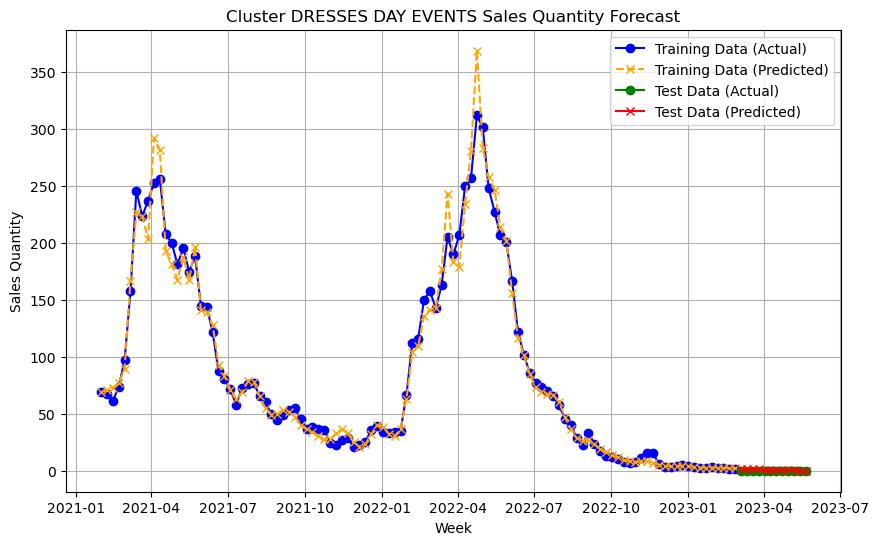

23:22:59 - cmdstanpy - INFO - Chain [1] start processing
23:22:59 - cmdstanpy - INFO - Chain [1] done processing


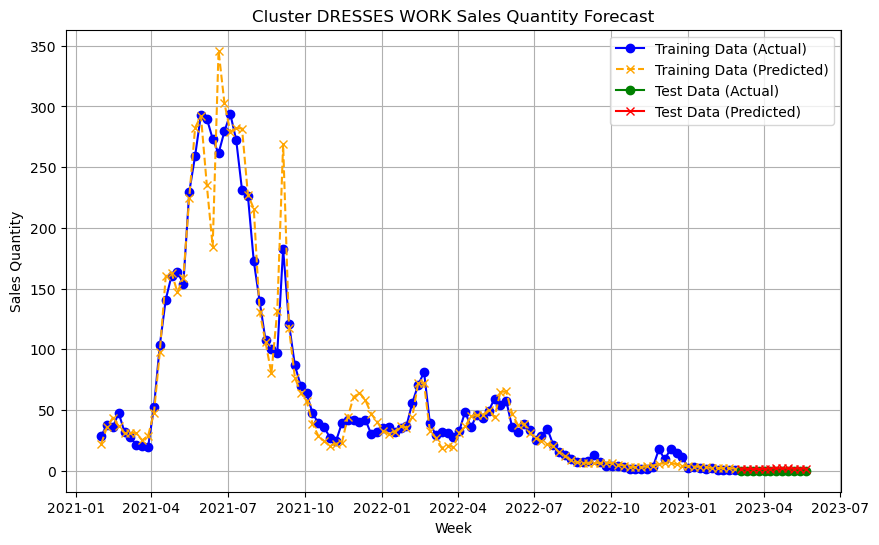

23:22:59 - cmdstanpy - INFO - Chain [1] start processing
23:22:59 - cmdstanpy - INFO - Chain [1] done processing


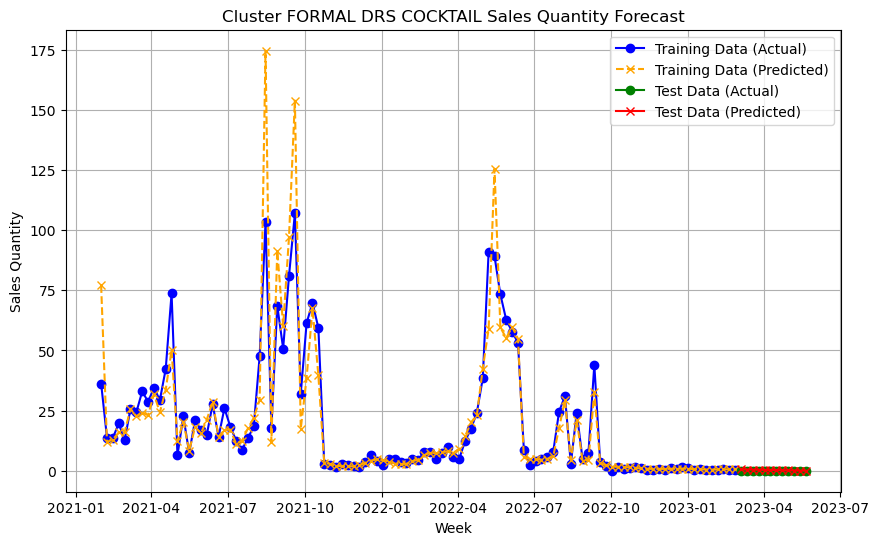

23:22:59 - cmdstanpy - INFO - Chain [1] start processing
23:22:59 - cmdstanpy - INFO - Chain [1] done processing


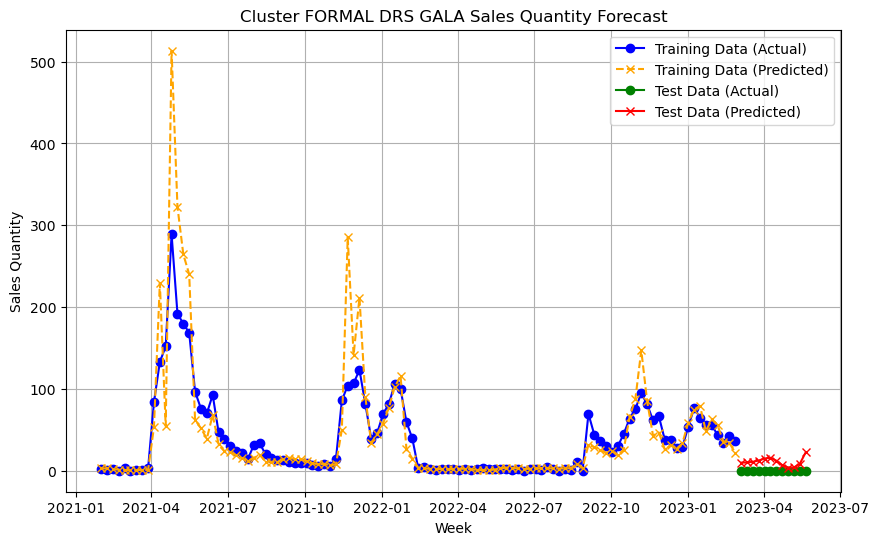

23:22:59 - cmdstanpy - INFO - Chain [1] start processing
23:22:59 - cmdstanpy - INFO - Chain [1] done processing


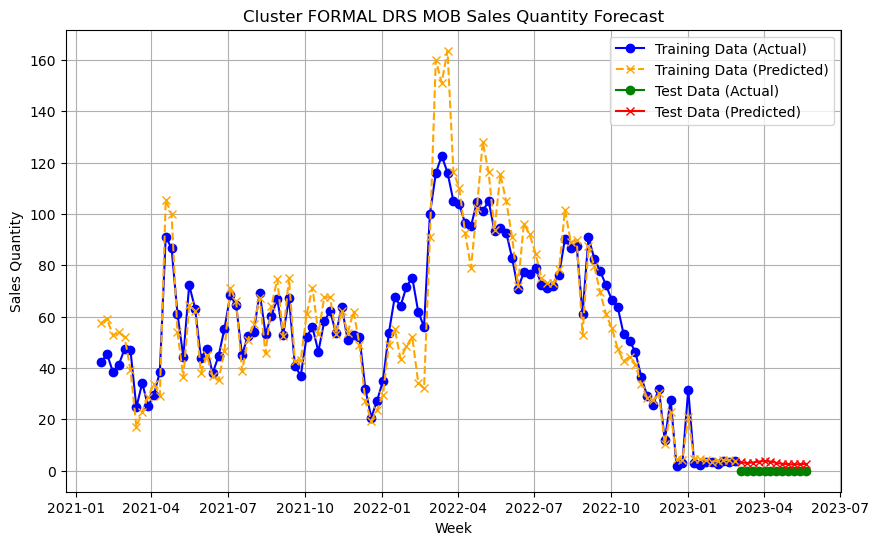

23:22:59 - cmdstanpy - INFO - Chain [1] start processing
23:22:59 - cmdstanpy - INFO - Chain [1] done processing


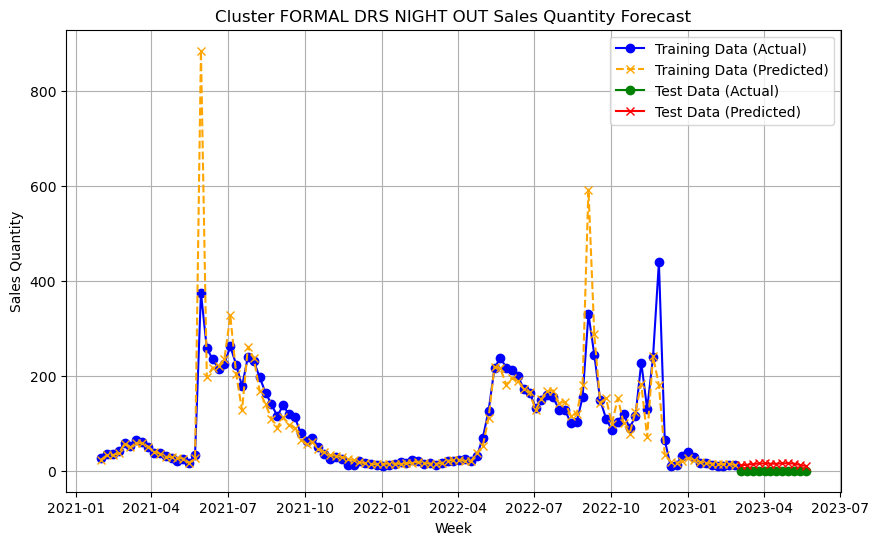

23:23:00 - cmdstanpy - INFO - Chain [1] start processing
23:23:00 - cmdstanpy - INFO - Chain [1] done processing


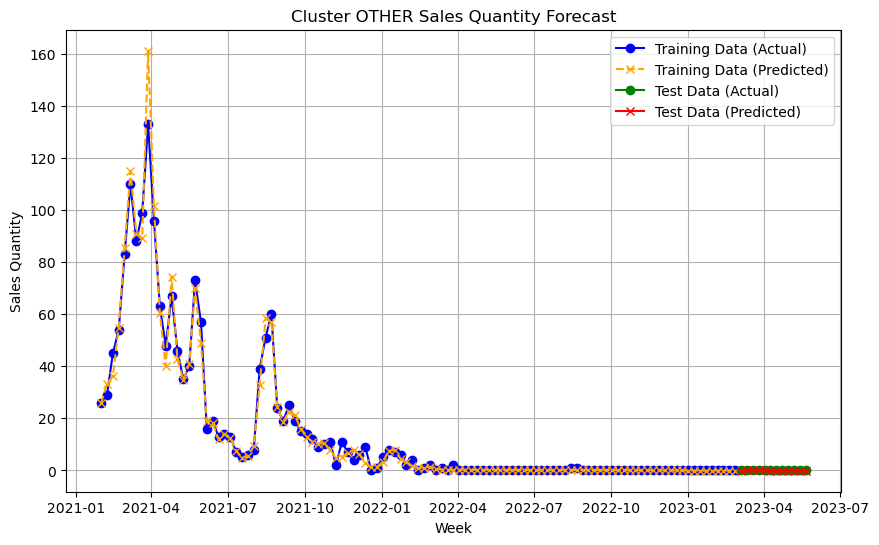

In [19]:
# Initialize a dictionary to hold forecasts and RMSE for each cluster
cluster_forecasts = {}
cluster_rmse = {}

# Define the number of periods to hold out for the test set
n_test_periods = 12  # For example, if your data is weekly, this would hold out the last 12 weeks for testing

# Loop over each unique cluster
for cluster in clustered_data_ctg['Cluster'].unique():
    # Filter the DataFrame for the current cluster
    cluster_data = clustered_data_ctg[clustered_data_ctg['Cluster'] == cluster]
    
    if len(cluster_data) <= (n_test_periods + 1):
        print(f"Cluster {cluster} has insufficient data. Skipping.")
        continue

    # Split the data into training and testing sets
    train_df = cluster_data.iloc[:-n_test_periods]
    test_df = cluster_data.iloc[-n_test_periods:]

    # Prepare the DataFrame for Prophet
    prophet_df = train_df.rename(columns={'WK_START_DT': 'ds', 'SALES_QTY': 'y'}).copy()
    prophet_df['y'] = np.log(prophet_df['y'] + 1)  # Log transformation

    # Initialize the Prophet model with specified parameters and holidays
    m = Prophet(
        growth='linear',
        seasonality_mode='multiplicative',
        interval_width=0.95,
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        holidays=holidays_df  # Assuming holidays_df is defined
    )

    # Add other regressors to the Prophet model
    m.add_regressor('SOH')
    m.add_regressor('SALES_AMT')
    m.add_regressor('ATB')
    m.add_regressor('RP_IND_prop')
    m.add_regressor('PVS')

    # Fit the model to the training data
    m.fit(prophet_df)

    # Create a future DataFrame for forecasting the entire period (training and test)
    all_period_future = m.make_future_dataframe(periods=n_test_periods, freq='W')

    # Add regressor values for the entire period
    all_period_future['ATB'] = np.concatenate([train_df['ATB'], test_df['ATB'].mean().repeat(n_test_periods)])
    all_period_future['SALES_AMT'] = np.concatenate([train_df['SALES_AMT'], test_df['SALES_AMT'].mean().repeat(n_test_periods)])
    all_period_future['SOH'] = np.concatenate([train_df['SOH'], test_df['SOH'].mean().repeat(n_test_periods)])
    all_period_future['RP_IND_prop'] = np.concatenate([train_df['RP_IND_prop'], test_df['RP_IND_prop'].mean().repeat(n_test_periods)])
    all_period_future['PVS'] = np.concatenate([train_df['PVS'], test_df['PVS'].mean().repeat(n_test_periods)])

    # Predict over the entire period
    all_period_forecast = m.predict(all_period_future)

    # Extract forecasted values for the training and test periods
    forecasted_train_values = np.expm1(all_period_forecast['yhat'][:-n_test_periods])
    forecasted_test_values = np.expm1(all_period_forecast['yhat'][-n_test_periods:])

    # Plot true vs. predicted values for this cluster
    plt.figure(figsize=(10, 6))
    # Plot training data (actual and predicted)
#     plt.plot(train_df['WK_START_DT'], np.expm1(prophet_df['y']), label='Training Data (Actual)', color='blue', marker='o')
    train_dates = np.array(train_df['WK_START_DT'])
    prophet_values = np.array(prophet_df['y'])
    plt.plot(train_dates, np.expm1(prophet_values), label='Training Data (Actual)', color='blue', marker='o')

    
    forecasted_values = np.array(forecasted_train_values)
    plt.plot(train_dates, forecasted_values, label='Training Data (Predicted)', color='orange', linestyle='--', marker='x')


#     plt.plot(train_df['WK_START_DT'], forecasted_train_values, label='Training Data (Predicted)', color='orange', linestyle='--', marker='x')

    # Plot test data (actual and predicted)
    # Convert them to NumPy arrays before indexing
    test_dates = np.array(test_df['WK_START_DT'])
    actual_values_array = np.array(actual_values)
    forecasted_test_values_array = np.array(forecasted_test_values)

    # Plotting the actual values
    plt.plot(test_dates, actual_values_array, label='Test Data (Actual)', color='green', marker='o')

    # Plotting the predicted values
    plt.plot(test_dates, forecasted_test_values_array, label='Test Data (Predicted)', color='red', marker='x')

    plt.title(f'Cluster {cluster} Sales Quantity Forecast')
    plt.xlabel('Week')
    plt.ylabel('Sales Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Print the RMSE for each cluster
for cluster, standardized_rmse in cluster_rmse.items():
    print(f'Cluster {cluster} RMSE: {standardized_rmse}')

# Replenishment model (last 12 week or a season)

## safety stock

assumption：

lead time = 2 weeks

z-score = 95%

In [20]:
rpdata = clustered_data.copy()

In [21]:
from datetime import datetime, timedelta
# Calculate the date 13 weeks ago from the most recent date

current_date = rpdata['WK_START_DT'].max()
last_13wk = current_date - timedelta(weeks=13)

# last_13wk
rpdata = rpdata[rpdata['WK_START_DT'] >= last_13wk]
rpdata

Cluster WK_START_DT  SALES_QTY  PROMO_DAYS  ATB  SOH  SALES_AMT  \
107    10160694-114  2023-02-19          0           7    0    6       0.00   
108    10160694-114  2023-02-26          2           7    0    7      89.94   
109    10160694-114  2023-03-05          0           1    0    5       0.00   
110    10160694-114  2023-03-12          2           7    0   10      89.94   
111    10160694-114  2023-03-19          0           1    0    7       0.00   
...             ...         ...        ...         ...  ...  ...        ...   
20820    99277550-1  2023-04-23          0           0    0   54       0.00   
20821    99277550-1  2023-04-30          0           0    0   35       0.00   
20822    99277550-1  2023-05-07          0           0    0   35       0.00   
20823    99277550-1  2023-05-14          0           0    0   36       0.00   
20824    99277550-1  2023-05-21          0           0    0   36       0.00   

       PVS  cost_per_unit  RP_IND_prop  HOLIDAY  
107    0.0      42.103448          0.0     True  
108    0.0      42.103448          0.0     True  
109    0.0      42.103448          0.0     True  
110    0.0      42.103448          0.0     True  
111    0.0      42.103448          0.0     True  
...    ...            ...          ...      ...  
20820  1.0      43.658227          0.0    False  
20821  4.0      43.658227          0.0    False  
20822  7.0      43.658227          0.0    False  
20823  2.0      43.658227          0.0    False  
20824  8.0      43.658227          0.0    False  

[2771 rows x 11 columns]

In [22]:
# rpdata["Cluster"].unique()

In [23]:
# Define the desired service level and lead time
desired_service_level = 0.95 ###adjust it as needed
lead_time_weeks = 2  ###adjust it as needed


# sales standard deviation
rpdata['Sales_StdDev'] = rpdata.groupby(['Cluster'])['SALES_QTY'].rolling(window=lead_time_weeks).std().reset_index(level=0, drop=True)
rpdata['Sales_StdDev'] = rpdata.groupby('Cluster')['Sales_StdDev'].shift(-(lead_time_weeks-1))


rpdata['Sales_StdDev'].fillna(0, inplace=True)

rpdata['Sales_StdDev'] = rpdata['Sales_StdDev'].round().astype(int)


# Display the resulting DataFrame with the standard deviation column
rpdata[["WK_START_DT","Cluster", "SALES_QTY", "Sales_StdDev",'SOH']]

WK_START_DT       Cluster  SALES_QTY  Sales_StdDev  SOH
107    2023-02-19  10160694-114          0             1    6
108    2023-02-26  10160694-114          2             1    7
109    2023-03-05  10160694-114          0             1    5
110    2023-03-12  10160694-114          2             1   10
111    2023-03-19  10160694-114          0             0    7
...           ...           ...        ...           ...  ...
20820  2023-04-23    99277550-1          0             0   54
20821  2023-04-30    99277550-1          0             0   35
20822  2023-05-07    99277550-1          0             0   35
20823  2023-05-14    99277550-1          0             0   36
20824  2023-05-21    99277550-1          0             0   36

[2771 rows x 5 columns]

In [24]:
from scipy.stats import norm

# Calculate the z-score for the desired service level
z_score = norm.ppf(desired_service_level)

# Calculate safety stock for each SKU
rpdata['Safety_Stock'] = z_score * rpdata['Sales_StdDev']

rpdata['Safety_Stock'] = rpdata['Safety_Stock'].round().astype(int)

rpdata[['WK_START_DT','Cluster','SALES_QTY', 'Sales_StdDev', 'Safety_Stock','SOH']].head()

WK_START_DT       Cluster  SALES_QTY  Sales_StdDev  Safety_Stock  SOH
107  2023-02-19  10160694-114          0             1             2    6
108  2023-02-26  10160694-114          2             1             2    7
109  2023-03-05  10160694-114          0             1             2    5
110  2023-03-12  10160694-114          2             1             2   10
111  2023-03-19  10160694-114          0             0             0    7

### lead time sales

In [25]:
# find the lead time sales

rpdata['LeadTimeSales'] = rpdata.groupby(['Cluster'])['SALES_QTY'].rolling(window=lead_time_weeks).sum().reset_index(level=0, drop=True)
rpdata['LeadTimeSales'] = rpdata.groupby('Cluster')['LeadTimeSales'].shift(-(lead_time_weeks-1))


## Reorder point = lead time sales + safety stock

In [26]:
rpdata['ReorderPoint'] = rpdata['LeadTimeSales'] + rpdata['Safety_Stock']
rpdata

Cluster WK_START_DT  SALES_QTY  PROMO_DAYS  ATB  SOH  SALES_AMT  \
107    10160694-114  2023-02-19          0           7    0    6       0.00   
108    10160694-114  2023-02-26          2           7    0    7      89.94   
109    10160694-114  2023-03-05          0           1    0    5       0.00   
110    10160694-114  2023-03-12          2           7    0   10      89.94   
111    10160694-114  2023-03-19          0           1    0    7       0.00   
...             ...         ...        ...         ...  ...  ...        ...   
20820    99277550-1  2023-04-23          0           0    0   54       0.00   
20821    99277550-1  2023-04-30          0           0    0   35       0.00   
20822    99277550-1  2023-05-07          0           0    0   35       0.00   
20823    99277550-1  2023-05-14          0           0    0   36       0.00   
20824    99277550-1  2023-05-21          0           0    0   36       0.00   

       PVS  cost_per_unit  RP_IND_prop  HOLIDAY  Sales_StdDev  Safety_Stock  \
107    0.0      42.103448          0.0     True             1             2   
108    0.0      42.103448          0.0     True             1             2   
109    0.0      42.103448          0.0     True             1             2   
110    0.0      42.103448          0.0     True             1             2   
111    0.0      42.103448          0.0     True             0             0   
...    ...            ...          ...      ...           ...           ...   
20820  1.0      43.658227          0.0    False             0             0   
20821  4.0      43.658227          0.0    False             0             0   
20822  7.0      43.658227          0.0    False             0             0   
20823  2.0      43.658227          0.0    False             0             0   
20824  8.0      43.658227          0.0    False             0             0   

       LeadTimeSales  ReorderPoint  
107              2.0           4.0  
108              2.0           4.0  
109              2.0           4.0  
110              2.0           4.0  
111              0.0           0.0  
...              ...           ...  
20820            0.0           0.0  
20821            0.0           0.0  
20822            0.0           0.0  
20823            0.0           0.0  
20824            NaN           NaN  

[2771 rows x 15 columns]

In [27]:
current_cc=None

for index, row in rpdata.iterrows():
    if current_cc!=rpdata.at[index,'Cluster']:
        current_cc=rpdata.at[index,'Cluster']
        count_rows=1
    else:
        count_rows+=1
        if count_rows==2:
            rpdata.at[index,'lastweek_soh']=rpdata.at[index-1, 'SOH']
rpdata

Cluster WK_START_DT  SALES_QTY  PROMO_DAYS  ATB  SOH  SALES_AMT  \
107    10160694-114  2023-02-19          0           7    0    6       0.00   
108    10160694-114  2023-02-26          2           7    0    7      89.94   
109    10160694-114  2023-03-05          0           1    0    5       0.00   
110    10160694-114  2023-03-12          2           7    0   10      89.94   
111    10160694-114  2023-03-19          0           1    0    7       0.00   
...             ...         ...        ...         ...  ...  ...        ...   
20820    99277550-1  2023-04-23          0           0    0   54       0.00   
20821    99277550-1  2023-04-30          0           0    0   35       0.00   
20822    99277550-1  2023-05-07          0           0    0   35       0.00   
20823    99277550-1  2023-05-14          0           0    0   36       0.00   
20824    99277550-1  2023-05-21          0           0    0   36       0.00   

       PVS  cost_per_unit  RP_IND_prop  HOLIDAY  Sales_StdDev  Safety_Stock  \
107    0.0      42.103448          0.0     True             1             2   
108    0.0      42.103448          0.0     True             1             2   
109    0.0      42.103448          0.0     True             1             2   
110    0.0      42.103448          0.0     True             1             2   
111    0.0      42.103448          0.0     True             0             0   
...    ...            ...          ...      ...           ...           ...   
20820  1.0      43.658227          0.0    False             0             0   
20821  4.0      43.658227          0.0    False             0             0   
20822  7.0      43.658227          0.0    False             0             0   
20823  2.0      43.658227          0.0    False             0             0   
20824  8.0      43.658227          0.0    False             0             0   

       LeadTimeSales  ReorderPoint  lastweek_soh  
107              2.0           4.0           NaN  
108              2.0           4.0           6.0  
109              2.0           4.0           NaN  
110              2.0           4.0           NaN  
111              0.0           0.0           NaN  
...              ...           ...           ...  
20820            0.0           0.0           NaN  
20821            0.0           0.0           NaN  
20822            0.0           0.0           NaN  
20823            0.0           0.0           NaN  
20824            NaN           NaN           NaN  

[2771 rows x 16 columns]

In [28]:
# Create a mask to identify the very first date row for each CC
mask = rpdata.groupby('Cluster').cumcount() == 0

# Drop the rows that match the mask
rpdata = rpdata[~mask]

# Reset the index after dropping rows
rpdata = rpdata.reset_index(drop=True)

## find left stock from previous period

In [29]:
# add reorder_flag
rpdata['reorder_amount'] = 0
rpdata['reorder_flag'] = None  
rpdata.head()

Cluster WK_START_DT  SALES_QTY  PROMO_DAYS  ATB  SOH  SALES_AMT  PVS  \
0  10160694-114  2023-02-26          2           7    0    7      89.94  0.0   
1  10160694-114  2023-03-05          0           1    0    5       0.00  0.0   
2  10160694-114  2023-03-12          2           7    0   10      89.94  0.0   
3  10160694-114  2023-03-19          0           1    0    7       0.00  0.0   
4  10160694-114  2023-03-26          0           0    0   12       0.00  0.0   

   cost_per_unit  RP_IND_prop  HOLIDAY  Sales_StdDev  Safety_Stock  \
0      42.103448          0.0     True             1             2   
1      42.103448          0.0     True             1             2   
2      42.103448          0.0     True             1             2   
3      42.103448          0.0     True             0             0   
4      42.103448          0.0    False             0             0   

   LeadTimeSales  ReorderPoint  lastweek_soh  reorder_amount reorder_flag  
0            2.0           4.0           6.0               0         None  
1            2.0           4.0           NaN               0         None  
2            2.0           4.0           NaN               0         None  
3            0.0           0.0           NaN               0         None  
4            0.0           0.0           NaN               0         None

In [30]:
sdsp1=rpdata.copy()

# RP model result

In [31]:
current_cc=None
count_row=0

for index, row in sdsp1.iterrows():
    sdsp1.at[index,'this_week_soh']=sdsp1.at[index,'lastweek_soh']-sdsp1.at[index,'SALES_QTY']
    
    if current_cc!=sdsp1.at[index,'Cluster']:
        current_cc=sdsp1.at[index,'Cluster']
        flag_count=1
        if sdsp1.at[index,'ReorderPoint']>sdsp1.at[index,'lastweek_soh']:
            sdsp1.at[index,'this_week_soh']=sdsp1.at[index,'lastweek_soh']-sdsp1.at[index,'SALES_QTY']
            sdsp1.at[index,'reorder_amount']=sdsp1.at[index,'ReorderPoint']-sdsp1.at[index,'lastweek_soh']
            sdsp1.at[index,'this_week_soh']+=sdsp1.at[index,'reorder_amount']
            count_row+=1
    else:
        flag_count+=1
        sdsp1.at[index,'lastweek_soh']=sdsp1.at[index-1, 'this_week_soh']
        sdsp1.at[index,'this_week_soh']=sdsp1.at[index,'lastweek_soh']-sdsp1.at[index,'SALES_QTY']
        if count_row==0 and sdsp1.at[index,'ReorderPoint']>sdsp1.at[index,'lastweek_soh']:
            sdsp1.at[index,'reorder_amount']=sdsp1.at[index,'ReorderPoint']-sdsp1.at[index,'lastweek_soh']
            sdsp1.at[index,'this_week_soh']+=sdsp1.at[index,'reorder_amount']
            count_row+=1
            if flag_count>=3:
                sdsp1.at[index-2,'reorder_flag']='Reorder'
        elif count_row!=0:
            count_row-=1
            
            
            
    
sdsp1

Cluster WK_START_DT  SALES_QTY  PROMO_DAYS  ATB  SOH  SALES_AMT  \
0     10160694-114  2023-02-26          2           7    0    7      89.94   
1     10160694-114  2023-03-05          0           1    0    5       0.00   
2     10160694-114  2023-03-12          2           7    0   10      89.94   
3     10160694-114  2023-03-19          0           1    0    7       0.00   
4     10160694-114  2023-03-26          0           0    0   12       0.00   
...            ...         ...        ...         ...  ...  ...        ...   
2568    99277550-1  2023-04-23          0           0    0   54       0.00   
2569    99277550-1  2023-04-30          0           0    0   35       0.00   
2570    99277550-1  2023-05-07          0           0    0   35       0.00   
2571    99277550-1  2023-05-14          0           0    0   36       0.00   
2572    99277550-1  2023-05-21          0           0    0   36       0.00   

      PVS  cost_per_unit  RP_IND_prop  HOLIDAY  Sales_StdDev  Safety_Stock  \
0     0.0      42.103448          0.0     True             1             2   
1     0.0      42.103448          0.0     True             1             2   
2     0.0      42.103448          0.0     True             1             2   
3     0.0      42.103448          0.0     True             0             0   
4     0.0      42.103448          0.0    False             0             0   
...   ...            ...          ...      ...           ...           ...   
2568  1.0      43.658227          0.0    False             0             0   
2569  4.0      43.658227          0.0    False             0             0   
2570  7.0      43.658227          0.0    False             0             0   
2571  2.0      43.658227          0.0    False             0             0   
2572  8.0      43.658227          0.0    False             0             0   

      LeadTimeSales  ReorderPoint  lastweek_soh  reorder_amount reorder_flag  \
0               2.0           4.0           6.0               0         None   
1               2.0           4.0           4.0               0         None   
2               2.0           4.0           4.0               0         None   
3               0.0           0.0           2.0               0         None   
4               0.0           0.0           2.0               0         None   
...             ...           ...           ...             ...          ...   
2568            0.0           0.0          53.0               0         None   
2569            0.0           0.0          53.0               0         None   
2570            0.0           0.0          53.0               0         None   
2571            0.0           0.0          53.0               0         None   
2572            NaN           NaN          53.0               0         None   

      this_week_soh  
0               4.0  
1               4.0  
2               2.0  
3               2.0  
4               2.0  
...             ...  
2568           53.0  
2569           53.0  
2570           53.0  
2571           53.0  
2572           53.0  

[2573 rows x 19 columns]

In [32]:
mask = sdsp1.groupby('Cluster').cumcount() == 12

# Drop the rows that match the mask
sdsp1 = sdsp1[~mask]

# Reset the index after dropping rows
sdsp1 = sdsp1.reset_index(drop=True)


In [34]:
sdsp1

Cluster WK_START_DT  SALES_QTY  PROMO_DAYS  ATB  SOH  SALES_AMT  \
0     10160694-114  2023-02-26          2           7    0    7      89.94   
1     10160694-114  2023-03-05          0           1    0    5       0.00   
2     10160694-114  2023-03-12          2           7    0   10      89.94   
3     10160694-114  2023-03-19          0           1    0    7       0.00   
4     10160694-114  2023-03-26          0           0    0   12       0.00   
...            ...         ...        ...         ...  ...  ...        ...   
2371    99277550-1  2023-04-16          0           0    0   53       0.00   
2372    99277550-1  2023-04-23          0           0    0   54       0.00   
2373    99277550-1  2023-04-30          0           0    0   35       0.00   
2374    99277550-1  2023-05-07          0           0    0   35       0.00   
2375    99277550-1  2023-05-14          0           0    0   36       0.00   

      PVS  cost_per_unit  RP_IND_prop  HOLIDAY  Sales_StdDev  Safety_Stock  \
0     0.0      42.103448          0.0     True             1             2   
1     0.0      42.103448          0.0     True             1             2   
2     0.0      42.103448          0.0     True             1             2   
3     0.0      42.103448          0.0     True             0             0   
4     0.0      42.103448          0.0    False             0             0   
...   ...            ...          ...      ...           ...           ...   
2371  9.0      43.658227          0.0    False             0             0   
2372  1.0      43.658227          0.0    False             0             0   
2373  4.0      43.658227          0.0    False             0             0   
2374  7.0      43.658227          0.0    False             0             0   
2375  2.0      43.658227          0.0    False             0             0   

      LeadTimeSales  ReorderPoint  lastweek_soh  reorder_amount reorder_flag  \
0               2.0           4.0           6.0               0         None   
1               2.0           4.0           4.0               0         None   
2               2.0           4.0           4.0               0         None   
3               0.0           0.0           2.0               0         None   
4               0.0           0.0           2.0               0         None   
...             ...           ...           ...             ...          ...   
2371            0.0           0.0          53.0               0         None   
2372            0.0           0.0          53.0               0         None   
2373            0.0           0.0          53.0               0         None   
2374            0.0           0.0          53.0               0         None   
2375            0.0           0.0          53.0               0         None   

      this_week_soh  
0               4.0  
1               4.0  
2               2.0  
3               2.0  
4               2.0  
...             ...  
2371           53.0  
2372           53.0  
2373           53.0  
2374           53.0  
2375           53.0  

[2376 rows x 19 columns]

In [35]:
# sdsp1.to_csv('final_result_1204.csv')